In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [15]:
import random
import numpy as np
import pylab as plt

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v3')

from rotate import shiftRotateXYZ
from utils.utils import midPoint
from plotting import scatter3dPlot
from parabolas import rotateData, fitLeicaData, newParabola
from processPTX import getRawXYZ, neighborFilter, ellipticalFilter, zLimitFilter, nearFilter

In [3]:
fpath = "/home/scratch/psalas/LASSI/15Mar/2020_03_16_09:09:14.ptx"
dts = None
sampleSize = None
ellipse = [-44., -6.5, 49., 49., 0]

In [4]:
# Read the raw data.
with open(fpath, 'r') as f:
    ls = f.readlines()

In [5]:
%%time
xo, yo, zo, io = getRawXYZ(ls, sampleSize=None)

Skipped 0 non-data lines
CPU times: user 50.1 s, sys: 3.37 s, total: 53.5 s
Wall time: 53.4 s


In [6]:
mask = io != 0.0
intensity = io[mask]
x = xo[mask]
y = yo[mask]
z = zo[mask]

In [7]:
x, y, z, mask = neighborFilter(x, y, z, 0.122)
intensity = intensity[mask]

neighborFilter reduces 18572039 points to 18261287 points (310752 filtered, 1.673225 %) using tol: 0.122000


In [8]:
x, y, z, dts, intensity = ellipticalFilter(x, y, z,
                                           ellipse[0], ellipse[1], ellipse[2],
                                           ellipse[3], ellipse[4],
                                           dts=dts, intensity=intensity)
print(len(x))

16625036


In [9]:
z = -z
zLimit = -80
x, y, z, dts, intensity = zLimitFilter(x, y, z, zLimit=zLimit, dts=dts, intensity=intensity)
print(len(x))

9176238


In [11]:
x, y, z, dts, intensity = nearFilter(x, y, z, tol=10., dts=dts, intensity=intensity)
print(len(x))

9176238


<IPython.core.display.Javascript object>


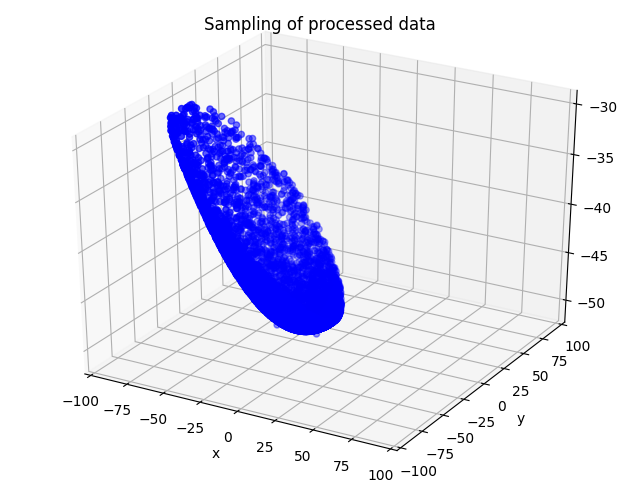

(<Figure size 640x480 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f45aec5ad10>)

In [12]:
sampleSize = 10000
lsIdx = random.sample(range(len(x)), sampleSize)
xr = x[lsIdx]
yr = y[lsIdx]
zr = z[lsIdx]
xlim = (-100, 100)
ylim = (-100, 100)
scatter3dPlot(xr, yr, zr, "Sampling of processed data", xlim=xlim, ylim=ylim)

In [13]:
%%time
# Fit a parabola to the data.
fitresult = fitLeicaData(xr, yr, zr, [60, 0, 0, -49, 0, 0], bounds=None, weights=None)

CPU times: user 7.42 s, sys: 6.57 s, total: 14 s
Wall time: 589 ms


In [16]:
c = fitresult.x
newX, newY, newZ = newParabola(xr, yr, zr, c[0], c[1], c[2], c[3], c[4], c[5])
xrr, yrr, zrr = rotateData(xr, yr, zr, c[4], c[5])
diff = zrr-newZ

<IPython.core.display.Javascript object>


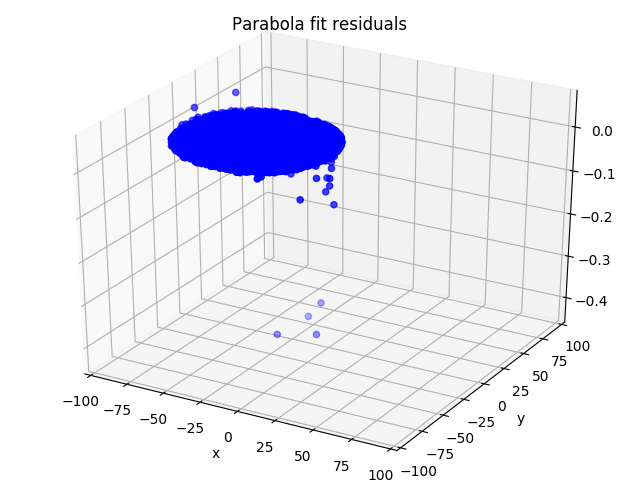

(<Figure size 640x480 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f45aeacd1d0>)

In [17]:
scatter3dPlot(xr, yr, diff, "Parabola fit residuals", xlim=xlim, ylim=ylim)

In [18]:
mask = abs(diff) < 0.01
print(mask.sum())

9923


In [19]:
%%time

mask = io != 0.0
intensity = io[mask]
x = xo[mask]
y = yo[mask]
z = zo[mask]

x, y, z, mask = neighborFilter(x, y, z, 0.122)
intensity = intensity[mask]

z = -z

xp, yp, zp = newParabola(x, y, z, c[0], c[1], c[2], c[3], c[4], c[5])

neighborFilter reduces 18572039 points to 18261287 points (310752 filtered, 1.673225 %) using tol: 0.122000
CPU times: user 37.9 s, sys: 17.8 s, total: 55.8 s
Wall time: 12.7 s


In [28]:
#%%timeit
xr_, yr_, zr_ = rotateData(x, y, z, c[4], c[5])

3.43 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
#%%timeit
xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, c[4], c[5], 0])

2.54 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
# Compare the outputs.
#len(xr_), len(xr)
#(xr_ - xr).sum(), (yr_ - yr).sum(), (zr_ - zr).sum()

(-2.9755742972064734e-09, 0.0, 2.852556055255029e-08)

In [36]:
diff = zr - zp
mask = abs(diff) < 0.005
print(mask.sum())

9808325


In [37]:
xrf = xr[mask]
yrf = yr[mask]
zrf = zr[mask]

In [38]:
xf = x[mask]
yf = y[mask]
zf = z[mask]

<IPython.core.display.Javascript object>


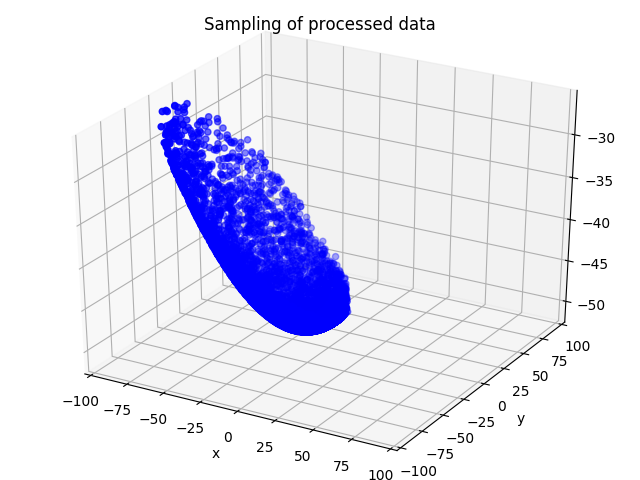

(<Figure size 640x480 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f45ae834c10>)

In [39]:
sampleSize = 10000
lsIdx = random.sample(range(len(xf)), sampleSize)
xr_ = xf[lsIdx]
yr_ = yf[lsIdx]
zr_ = zf[lsIdx]
xlim = (-100, 100)
ylim = (-100, 100)
scatter3dPlot(xr_, yr_, zr_, "Sampling of processed data", xlim=xlim, ylim=ylim)

In [40]:
r = 51
xc = np.nanmin(xrf)+r
yc = np.nanmin(yrf)+r
circular_mask = (xrf - xc)**2 + (yrf - yc)**2 <= r**2.
print(circular_mask.sum())
xfc = xrf[circular_mask]
yfc = yrf[circular_mask]
zfc = zrf[circular_mask]

9807587


<IPython.core.display.Javascript object>


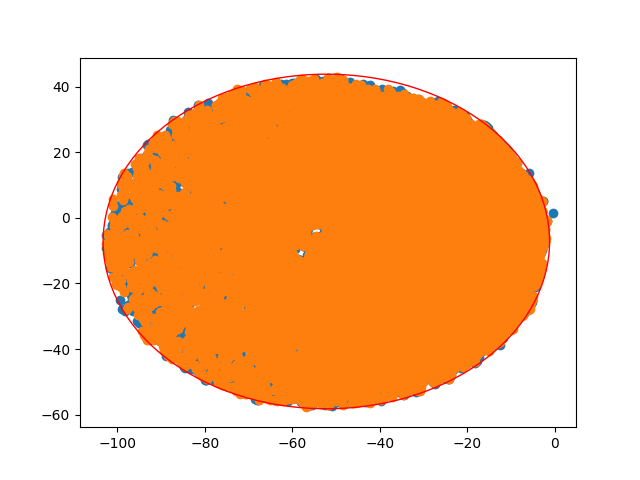

In [41]:
sampleSize = 30000

plt.figure()

lsIdx = random.sample(range(len(xrf)), sampleSize)
xr_ = xrf[lsIdx]
yr_ = yrf[lsIdx]
zr_ = zrf[lsIdx]
plt.scatter(xr_, yr_)

lsIdx = random.sample(range(len(xfc)), sampleSize)
xr_ = xfc[lsIdx]
yr_ = yfc[lsIdx]
zr_ = zfc[lsIdx]
plt.scatter(xr_, yr_)
#plt.scatter(c[1], c[2])
#plt.scatter(np.nanmedian(xrf), np.nanmedian(yrf))
#plt.scatter(midPoint(xf), midPoint(yf), c='r')

r = 51
circle1 = plt.Circle((np.nanmin(xrf)+r, np.nanmin(yrf)+r), r, color='r', fill=False)
plt.gca().add_artist(circle1)

In [ ]:
c[1], c[2]